### libraries

In [1]:
import numpy as np
import pandas as pd
import pysubgroup as ps
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
import seaborn as sns



# Data

Описание данных: https://www.kaggle.com/c/titanic

In [7]:
db = pd.read_csv("./data/train.csv")

In [10]:
891 - db.Survived.sum()

549

In [8]:
print(db.info())
print(db.describe())
print(db.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.

In [732]:
#Minor transformation
# Убираем неопределённые значения
db.Embarked.fillna("S", inplace=True) # Только 2 таких, обощить их нельзя
db["IsAgeNA"] = db.Age.isna() # А тут таких много, вдруг есть закономерность. Сохраним.
db.Age.fillna(db.Age.mean(), inplace=True) # Средний возраст, почему бы и нет
catVars = ["PassengerId","Survived","Pclass","Sex","Cabin","Embarked"]
db[catVars] = db[catVars].astype("category")

In [733]:
db.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,IsAgeNA
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False


In [734]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null category
Survived       891 non-null category
Pclass         891 non-null category
Name           891 non-null object
Sex            891 non-null category
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null category
Embarked       891 non-null category
IsAgeNA        891 non-null bool
dtypes: bool(1), category(6), float64(2), int64(2), object(2)
memory usage: 103.2+ KB


### Constants and variables

In [817]:
RANDOM = 42

cv_Num=20 # Количество итераций (случайных сплитов на train-test) для кросс валидации
cv_prop = 0.5 # Пропорция всех наблюдений, попадающих в обучающую выборку при кросс-валидации

In [736]:
result = pd.DataFrame(None) #здесь будут результаты кросс-валидации всех моделей

### Functions for prediction and cross-validation

Обозначим функции для обучения и предсказания:

In [1098]:
# Please set dummy_na=True when you call pd.get_dummies if you want to use this solution to invert 
#the "dummification" and your data contains any NaNs. Setting dummy_na=True will always add a "nan" column,
#even if that column is all 0s

def TrainModel(X, y):
    scaler = StandardScaler()
    X_ohe = pd.get_dummies(X, dummy_na=True)
    X_ohe = scaler.fit_transform(X_ohe)
    return LogisticRegression(random_state=0,solver="lbfgs").fit(X_ohe,y), scaler
def PredictByModel(m, X, scaler):
    X_ohe = pd.get_dummies(X,dummy_na=True)
    X_ohe = scaler.transform(X_ohe)
    return m.predict(X_ohe)

In [738]:
def cross_val(cv_Num, db, cv_prop, name, result, columns_to_drop):  
    temp_acc = []
    temp_coefs = []
    for i in range(cv_Num): #цикл многократного разбиения на трейн и тест
        
        # Разбиение на train-test
        X_train, X_test, y_train, y_test = train_test_split(db.drop(columns = columns_to_drop), 
                                                                        db.Survived, test_size=cv_prop, )
            
        model, scaler = TrainModel(X_train, y_train)
        
        # Предсказание
        predictions = PredictByModel(model, X_test, scaler)

        # Считаем качество модели
        quality = accuracy_score(y_test, predictions)
        #Сохраняем результат
        temp_acc.append(quality)
        temp_coefs.append(model.coef_)

    #переменная full показывает, нужно ли возвращать X_test, y_test, predictions
    result[name] = temp_acc
    coefs = np.mean(np.array(temp_coefs), axis=0)
    
    #Переменные тест и трейн нужны для последующего применения SD на них
    return {'Accuracy': result, 'X_test': X_test, 'y_test': y_test, 'Preds': predictions, 'Coefs': coefs}

# Base model

In [739]:
db_initial = db.copy()
columns_to_drop = ['Survived','PassengerId',  'Name', 'Ticket',  'Cabin'] 

In [740]:
CrossVal_result = cross_val(cv_Num, db_initial, cv_prop, 'BaseModel', result, columns_to_drop)

In [741]:
CrossVal_result['Accuracy']

,BaseModel
0,0.773543
1,0.807175
2,0.762332
3,0.802691
4,0.793722
5,0.793722
6,0.784753
7,0.773543
8,0.800448
9,0.791480


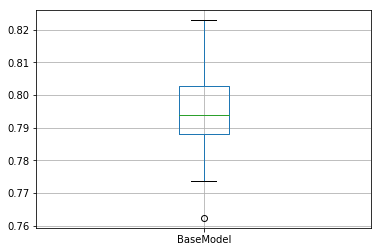

In [742]:
result.boxplot()

# Feature engineering

In [743]:
# Вдруг есть закономерность у тех, у кого было больше 1 каюты. Сохраним.
db["SeveralCabins"] = [x.find(" ") > -1 if type(x) is not float else np.nan for x in db.Cabin ] 

In [744]:
db["Deck"] = [x[0] if type(x) is not float else np.nan for x in db.Cabin ] 

In [745]:
db["CabinNum"] = [x[1:].split(" ")[0] if type(x) is not float else np.nan for x in db.Cabin ] 

В 4 строках (75, 128, 699, 715) кабина указана сначала "F" - номер палубы, потом новая буква и цифра каюты.
Цифры кают не считались

Добавим цифры кают вручную:

In [746]:
listCabinNum = list(db.CabinNum)
listCabinNum[75] = '73'
listCabinNum[128] = '69'
listCabinNum[699] = '63'
listCabinNum[715] = '73'
new_df = pd.DataFrame({'CabinNum': listCabinNum})
db.update(new_df)

В нескольких строках указана только палуба без каюты:

Добавим вместо каюты '' nan:

In [747]:
db.CabinNum = db['CabinNum'].replace('', np.nan)

В зависимости от того, на каком борту находится каюта (четные - левый, нечетные - правый), добавим новый признак.
Необходимо учитывать, что на палубе Е все каюты, кроме 121 находятся на правом борту
(Информация полученая с карт палуб Титаника: https://www.encyclopedia-titanica.org/titanic-deckplans/f-deck.html)

In [748]:
g = lambda x: "Left" if int(x)%2==0 else "Right"

In [749]:
db['Side'] = [g(x) if type(x) is not float else np.nan for x in db.CabinNum] 

На палубе E все кабины с правого борта, кроме кабины 121 (индекс строки 752):

In [750]:
for i in db.loc[db.Deck == 'E'].index:
    db.at[i, 'Side'] = 'Right'
db.at[751, 'Side'] = 'Left'
db.at[823, 'Side'] = 'Left'

Добавим признак, показывающий, кабина была в носовой, центральной или кормовой части корабля. (Известно, что сначала затонул нос, потом корабль сломался пополам, потом затонула корма). При этом, судя по схемам, расположение кабин на разных палубах было разным. То есть нельзя просто сказать, что кабины 1-50 это нос, 50-70 середина, 70-100 корма.

In [751]:
for i in range(len(db)):
    deckNum = db.loc[i, :].Deck
    cabinNum = db.loc[i, :].CabinNum
    if cabinNum is not np.nan :
        cabinNum = int(cabinNum)
        if deckNum == 'A' :
            if cabinNum < 36 : db.at[i, 'Part'] = 'Bow'
            elif cabinNum > 35 : db.at[i, 'Part'] = 'Stern'
        elif deckNum == 'B':
            if cabinNum < 51 : db.at[i, 'Part'] = 'Bow'
            elif cabinNum > 50 : db.at[i, 'Part'] = 'Middle'
        elif deckNum == 'C':
            if cabinNum < 61 : db.at[i, 'Part'] = 'Bow'
            elif cabinNum > 60 : db.at[i, 'Part'] = 'Middle'
        elif deckNum == 'D':
            if cabinNum < 51 : db.at[i, 'Part'] = 'Bow'
            elif cabinNum > 50 : db.at[i, 'Part'] = 'Stern'
        elif deckNum == 'E':
            if cabinNum < 27 : db.at[i, 'Part'] = 'Bow'
            elif cabinNum > 26 & cabinNum < 71 : db.at[i, 'Part'] = 'Middle'
            elif cabinNum > 70 : db.at[i, 'Part'] = 'Stern'  
        elif deckNum == 'F':
            if cabinNum < 34 : db.at[i, 'Part'] = 'Stern'
            elif cabinNum > 33 : db.at[i, 'Part'] = 'Bow'
        elif deckNum == 'G':
            db.at[i, 'Part'] = 'Stern'
#    elif deckNum is float:
#        pass

In [752]:
db.SeveralCabins = db.SeveralCabins.astype("bool")
db.Deck = db.Deck.astype("category")
db.CabinNum = db.CabinNum.astype("float64")
db.Side = db.Side.astype("category")
db.Part = db.Part.astype("category")

Также историческим фактом является то, что пассажиры третьего класса разделялись по половому признаку - каюты для мужчин были на носу корабля, женщин - на корме

В следующем источнике сказано, что так разелялись только не семейные мужчины и женщины
https://books.google.ru/books?id=zR6PDwAAQBAJ&pg=PT278&lpg=PT278&dq=каюты+титаника+разделение+по+полу&source=bl&ots=Gz_8aZsRe6&sig=ACfU3U3OhOhbaNVkfF-dymRzT3q76FmkqQ&hl=ru&sa=X&ved=2ahUKEwj8toiGwaHpAhUc6aYKHXSDDYUQ6AEwEnoECAoQAQ#v=onepage&q=каюты%20титаника%20разделение%20по%20полу&f=false

В других же источниках приводтится информация о разделении по половому признаку даже семей
https://ru.wikipedia.org/wiki/Гудвин,_Сидней_Лесли

In [753]:
for i in range(len(db)):
    Sex = str(db.loc[i, :].Sex)
    Class = int(db.loc[i, :].Pclass)
    Age = float(db.loc[i, :].Age)
    Part = str(db.loc[i, :].Part)
    if Class == 3 :
        if Part != np.nan :
            if Sex == 'female' : db.at[i, 'Part'] = 'Stern' #женщин селили в корме
           # маленькие дети- мальчики скорее всего были с матерями в корме (врядли у них были няни, т.к. третий класс - это бедные иммигранты)
            elif Age < 5 : db.at[i, 'Part'] = 'Stern'
            #мальчики постарше и мужчины были в носовой части
            else: db.at[i, 'Part'] = 'Bow'
        

In [754]:
Train = db.loc[db.Cabin.notna()].drop(columns = ['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin', 'SeveralCabins', 'Side', 'Part'])
Predict = db.loc[~db.Cabin.notna()].drop(columns = ['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin', 'SeveralCabins', 'Side', 'Part'])

In [755]:
db.loc[db.Cabin.notna()].loc[db.CabinNum.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,IsAgeNA,SeveralCabins,Deck,CabinNum,Side,Part
292,293,0,2,"Levy, Mr. Rene Jacques",male,36.0,0,0,SC/Paris 2163,12.8750,D,C,False,False,D,NaN,NaN,NaN
327,328,1,2,"Ball, Mrs. (Ada E Hall)",female,36.0,0,0,28551,13.0000,D,S,False,False,D,NaN,NaN,NaN
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5000,T,S,False,False,T,NaN,NaN,NaN
473,474,1,2,"Jerwan, Mrs. Amin S (Marie Marthe Thuillard)",female,23.0,0,0,SC/AH Basle 541,13.7917,D,C,False,False,D,NaN,NaN,NaN


In [756]:
print(Train.shape)
print(Predict.shape)

(204, 10)
(687, 10)


In [757]:
Train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsAgeNA,Deck,CabinNum
1,1,female,38.0,1,0,71.2833,C,False,C,85.0
3,1,female,35.0,1,0,53.1000,S,False,C,123.0
6,1,male,54.0,0,0,51.8625,S,False,E,46.0
10,3,female,4.0,1,1,16.7000,S,False,G,6.0
11,1,female,58.0,0,0,26.5500,S,False,C,103.0


In [758]:
ohe_Train = pd.get_dummies(Train, columns = ['Pclass', 'Sex', 'Embarked'], dummy_na=True)

In [759]:
ohe_Predict = pd.get_dummies(Predict, columns = ['Pclass', 'Sex', 'Embarked'],dummy_na=True)

Обучим модель предсказывать палубу:

In [760]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
#провалидируем классификатор с помощью кросс-валидации на 5 фолдах с расчетом среднего значения точности
SKF = StratifiedKFold(n_splits = 5,shuffle = True,random_state = 40)
Res = cross_val_score(RandomForestClassifier(),ohe_Train.drop(columns = ['Deck', 'CabinNum']), ohe_Train[['Deck']].values.ravel(),cv = SKF)
print("CV accuracy score: {:.2f}%".format(Res.mean()*100))

CV accuracy score: 35.57%


Устроит ли точность предсказания палубы? Пока оставим.

In [761]:
RANDOM_SEED = 42
def TrainRFC(X, Y, random = RANDOM_SEED) :
    ohe_X = pd.get_dummies(X, columns = ['Pclass', 'Sex', 'Embarked'], dummy_na=True)
    Model_RFC = RandomForestClassifier(random_state = random, n_jobs = -1)
    return Model_RFC.fit(ohe_X,Y)

In [762]:
def PredictByRFC(m, X):
    X_ohe = pd.get_dummies(X,dummy_na=True)
    return m.predict(X_ohe)

In [763]:
Model_RFC = TrainRFC(Train.drop(columns = ['Deck', 'CabinNum']), Train[['Deck']].values.ravel())
pred_rf = PredictByRFC(Model_RFC, Predict.drop(columns = ['Deck', 'CabinNum']))

In [764]:
Predict.Deck = pd.Series(pred_rf, index = Predict.index).astype("category")

Обучим модель предсказывать каюту:


In [765]:
pass

### Предсказание после добавления признаков

Вернем к Predict и Train колонки, исключенные перед предсказанием палубы:

In [766]:
#train part with dummies and previously dropped columns 'Survived', 'SeveralCabins', 'Side', 'Part'
first_part = pd.concat([Train, db.loc[db.Cabin.notna()][['Survived', 'SeveralCabins', 'Side', 'Part']]], axis = 1)
#predict part with dummies and previously dropped columns 'Survived', 'SeveralCabins', 'Side', 'Part'
second_part = pd.concat([Predict, db.loc[~db.Cabin.notna()][['Survived', 'SeveralCabins', 'Side', 'Part']]], axis = 1) 

In [767]:
first_part.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 1 to 889
Data columns (total 14 columns):
Pclass           204 non-null category
Sex              204 non-null category
Age              204 non-null float64
SibSp            204 non-null int64
Parch            204 non-null int64
Fare             204 non-null float64
Embarked         204 non-null category
IsAgeNA          204 non-null bool
Deck             204 non-null category
CabinNum         200 non-null float64
Survived         204 non-null category
SeveralCabins    204 non-null bool
Side             200 non-null category
Part             200 non-null category
dtypes: bool(2), category(7), float64(3), int64(2)
memory usage: 12.3 KB


Объединим Predict и Train:

In [768]:
final = pd.concat([first_part, second_part], ignore_index = True)
final.Deck = final.Deck.astype("category")

In [769]:
final.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'IsAgeNA',
       'Deck', 'CabinNum', 'Survived', 'SeveralCabins', 'Side', 'Part'],
      dtype='object')

In [770]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Pclass           891 non-null category
Sex              891 non-null category
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Embarked         891 non-null category
IsAgeNA          891 non-null bool
Deck             891 non-null category
CabinNum         200 non-null float64
Survived         891 non-null category
SeveralCabins    891 non-null bool
Side             200 non-null category
Part             679 non-null category
dtypes: bool(2), category(7), float64(3), int64(2)
memory usage: 43.7 KB


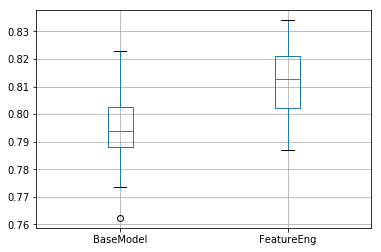

In [779]:
columns_to_drop = ['Survived','CabinNum'] 
CrossVal_result = cross_val(cv_Num, final, cv_prop, 'FeatureEng', result, columns_to_drop)
CrossVal_result['Accuracy'].boxplot()

In [780]:
res = CrossVal_result['Accuracy'].copy()

# Subgroup Discovery

In [781]:
def find_subgroups(db_sg, ignore = ['error'], nom_sel = True)  :
    target = ps.NominalTarget(target_selector=ps.NominalSelector('error', nom_sel))
    # Интересует именно ошибки, поэтому True
    searchSpace = ps.create_selectors(db_sg, ignore= ignore) 
    # Технически есть ещё Survived, но он нам может подсказать, в каком направлении происходит ошибка, поэтому оставляем
    task = ps.SubgroupDiscoveryTask(
    db_sg,
    target=target,
    search_space=searchSpace,
    result_set_size = 5, # на выход получаем 5 подгрупп
    depth = 3, # Каждая подгруппа описывается не более чем 3 предикатами
    qf = ps.StandardQF(1) # Функция качества на базе Chi2
    )

    return ps.BeamSearch().execute(task)

In [782]:
db_sg = pd.concat([X_test, y_test], axis = 1)
db_sg["error"] = predictions != y_test
db_sg.error.describe()
#243 верных из 295

count       446
unique        2
top       False
freq        365
Name: error, dtype: object

In [783]:
db_sg.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'IsAgeNA',
       'Deck', 'SeveralCabins', 'Side', 'Part', 'Survived', 'error'],
      dtype='object')

In [784]:
db_sg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446 entries, 607 to 450
Data columns (total 14 columns):
Pclass           446 non-null category
Sex              446 non-null category
Age              446 non-null float64
SibSp            446 non-null int64
Parch            446 non-null int64
Fare             446 non-null float64
Embarked         446 non-null category
IsAgeNA          446 non-null bool
Deck             446 non-null category
SeveralCabins    446 non-null bool
Side             87 non-null category
Part             333 non-null category
Survived         446 non-null category
error            446 non-null bool
dtypes: bool(3), category(7), float64(2), int64(2)
memory usage: 22.7 KB


Попробуем описать наблюдения, в которых у нас ошибки с помощью методов SD.

In [785]:
results = find_subgroups(db_sg)

In [786]:
for (q,sg) in results:
    print(str(q) + ":\t" + str(sg.subgroup_description))

0.06300649520400571:	Survived=1 AND Sex=male
0.05423897524583241:	Survived=1 AND Sex=male AND IsAgeNA=False
0.050156850127692096:	Survived=1 AND SeveralCabins=True AND Sex=male
0.04750749059904683:	Survived=1 AND Sex=male AND Embarked=S
0.04628586941221421:	Survived=1 AND Sex=male AND Parch: [0:1[


Модель плохо работает на выживших мужчинах, что вполне логично (в шлюпки сажали в первую очередь женщин)

In [787]:
db_sg[["Survived","Sex", "SeveralCabins", "error"]].groupby(["Survived","SeveralCabins", "Sex"]).agg([np.size,np.sum,np.mean])

error                
                               size   sum      mean
Survived SeveralCabins Sex                         
0        False         female     3   3.0  1.000000
                       male      26   9.0  0.346154
         True          female    39  22.0  0.564103
                       male     223   2.0  0.008969
1        False         female    29   0.0  0.000000
                       male      18   9.0  0.500000
         True          female    77   8.0  0.103896
                       male      31  28.0  0.903226

Уберем Survived из пространства поиска

In [788]:
results = find_subgroups(db_sg, ignore=['error', 'Survived'])

In [789]:
for (q,sg) in results:
    print(str(q) + ":\t" + str(sg.subgroup_description))

0.03876510687928572:	Part=Stern
0.03407468479157031:	Part=Stern AND Pclass=3
0.031626415170222605:	Part=Stern AND Pclass=3 AND Sex=female
0.03121920810794506:	Part=Stern AND Sex=female
0.030812001045667513:	Part=Stern AND SeveralCabins=True


In [790]:
final.loc[final.Pclass == 3].groupby(['Part']).size()

Part
Bow       334
Middle      0
Stern     157
dtype: int64

Без переменной Survived выделяются  группы, показывающие, что модель сильно ошибается на пассажирах с кормы из 3 класса

Если убрать факт выживания из пространства поиска, показываются круппы "Корма"+"3 класс", но исторически известно, что 3 класс делили по половому признаку, то есть, группа "Корма"+"3 класс" - это, по сути, женщины.

Уберем некоторые признаки из пространства поиска

In [791]:
results = find_subgroups(db_sg, ignore=['error', 'Sex', 'Survived', 'Part'])

In [792]:
for (q,sg) in results:
    print(str(q) + ":\t" + str(sg.subgroup_description))

0.02185847292324398:	SibSp: [1:2[
0.021008868064911826:	Fare: [10.50:23.25[ AND SibSp: [1:2[ AND SeveralCabins=True
0.02060166100263428:	Fare: [10.50:23.25[ AND SibSp: [1:2[
0.01960123871382895:	SibSp: [1:2[ AND Embarked=S
0.01897786000120654:	Side=Left


у людей с 1-2 sibling средняя ошибка выше, чем у других: 0.25

In [793]:
db_sg.groupby(['SibSp']).agg({np.mean, np.size})

Age            Parch             Fare            IsAgeNA            \
        size       mean  size      mean   size       mean    size      mean   
SibSp                                                                         
0      302.0  31.153110   302  0.168874  302.0  25.921230     302  0.228477   
1      106.0  29.770827   106  0.632075  106.0  40.126376     106  0.132075   
2       17.0  23.788131    17  0.529412   17.0  67.983329      17  0.117647   
3        6.0  21.016225     6  1.500000    6.0  65.866683       6  0.500000   
4        7.0   6.000000     7  1.428571    7.0  33.080357       7  0.000000   
5        4.0  12.500000     4  2.000000    4.0  46.900000       4  0.000000   
8        4.0  29.699118     4  2.000000    4.0  69.550000       4  1.000000   

      SeveralCabins           error            
               size      mean  size      mean  
SibSp                                          
0               302  0.847682   302  0.155629  
1               106  0.745283   106  0.273585  
2                17  0.823529    17  0.235294  
3                 6  1.000000     6  0.000000  
4                 7  1.000000     7  0.142857  
5                 4  1.000000     4  0.000000  
8                 4  1.000000     4  0.000000

Более того, очень высокая ошибка у людей с 1 sibling и заданным интервалом стоимости билета

In [794]:
db_sg.loc[(db_sg.Fare > 10) & (db_sg.Fare < 23)].groupby(['SibSp']).agg({np.mean, np.size})

Age            Parch            Fare            IsAgeNA            \
       size       mean  size      mean  size       mean    size      mean   
SibSp                                                                       
0      58.0  33.393043    58  0.258621  58.0  13.150860      58  0.068966   
1      33.0  23.763342    33  0.363636  33.0  16.378791      33  0.333333   
2       4.0  20.000000     4  0.250000   4.0  17.341650       4  0.000000   

      SeveralCabins           error            
               size      mean  size      mean  
SibSp                                          
0                58  0.965517    58  0.189655  
1                33  0.939394    33  0.484848  
2                 4  1.000000     4  0.000000

Добавим эти признаки, и посмотрим, на каком прирост будет больше

### Первый набор подгрупп


Первую группу не рассматриваем, поскольку в предикатах - целевая переменная

    0.06300649520400571:	Survived=1 AND Sex=male
    0.05423897524583241:	Survived=1 AND Sex=male AND IsAgeNA=False
    0.050156850127692096:	Survived=1 AND SeveralCabins=True AND Sex=male
    0.04750749059904683:	Survived=1 AND Sex=male AND Embarked=S
    0.04628586941221421:	Survived=1 AND Sex=male AND Parch: [0:1[

### Второй набор подгрупп

    0.03876510687928572:	Part=Stern
    0.03407468479157031:	Part=Stern AND Pclass=3
    0.031626415170222605:	Part=Stern AND Pclass=3 AND Sex=female
    0.03121920810794506:	Part=Stern AND Sex=female
    0.030812001045667513:	Part=Stern AND SeveralCabins=True

Поочередно будем добавлять признаки, выборочно, не все (1 подгруппа - 1 признак) и смотреть, как меняется качество

In [795]:
subgroup2 = pd.Series([((final.loc[x, "Pclass"] == 3) & (final.loc[x, "Part"] == 'Stern')) for x in range(len(final))])

In [796]:
subgroup3 = pd.Series([((final.loc[x, "Pclass"] == 3) & (final.loc[x, "Part"] == 'Stern') & (final.loc[x, "Sex"] == 'female')) for x in range(len(final))])

In [797]:
subgroup4 = pd.Series([((final.loc[x, "Part"] == 'Stern') & (final.loc[x, "Sex"] == 'female')) for x in range(len(final))])

In [798]:
subgroup1 = pd.Series([((final.loc[x, "Part"] == 'Stern') & (final.loc[x, "SeveralCabins"] == True)) for x in range(len(final))])

### Третий набор подгрупп

    0.02185847292324398:	SibSp: [1:2[
    0.021008868064911826:	Fare: [10.50:23.25[ AND SibSp: [1:2[ AND SeveralCabins=True
    0.02060166100263428:	Fare: [10.50:23.25[ AND SibSp: [1:2[
    0.01960123871382895:	SibSp: [1:2[ AND Embarked=S
    0.01897786000120654:	Side=Left

Первую и поседнюю подгруппу набора не рассматриваем, т.к. они состоят всего лишь из 1 предиката

In [801]:
subgroup5 = pd.Series([((final.loc[x, "SeveralCabins"] == True) & (final.loc[x, "Fare"] >= 10.5) & (final.loc[x, "Fare"] < 23.25) & (final.loc[x, "SibSp"] == 1)) for x in range(len(final))])

In [802]:
subgroup6 = pd.Series([((final.loc[x, "Fare"] >= 10.5) & (final.loc[x, "Fare"] < 23.25) & (final.loc[x, "SibSp"] == 1)) for x in range(len(final))])

In [803]:
subgroup7 = pd.Series([((final.loc[x, "SibSp"] == 1) & (final.loc[x, "Embarked"] == 'S')) for x in range(len(final))])

In [818]:
list_of_features = [subgroup1, subgroup2, subgroup3, subgroup4, subgroup5, subgroup6, subgroup7]
list_of_names = ['subgroup1', 'subgroup2', 'subgroup3', 'subgroup4', 'subgroup5', 'subgroup6', 'subgroup7']
columns_to_drop = ['Survived','CabinNum'] 

for i in range(0,7) :
    df = pd.concat([final, list_of_features[i]], axis = 1)
    CrossVal_result= cross_val(cv_Num, df, cv_prop, list_of_names[i], result, columns_to_drop)

In [820]:
result = CrossVal_result['Accuracy']

In [821]:
final2 = pd.concat([final, subgroup1, subgroup2, subgroup3, subgroup4, subgroup5, subgroup6, subgroup7], axis = 1)
final2 = final2.rename({0: 'subgroup1', 1: 'subgroup2', 2: 'subgroup3', 3: 'subgroup4', 4: 'subgroup5' , 
               5: 'subgroup6', 6: 'subgroup7'}, axis = 1)

In [832]:
columns_to_drop = ['Survived','CabinNum'] 
CrossVal_results_SD1 = cross_val(cv_Num, final2, cv_prop, 'SD1', result, columns_to_drop)

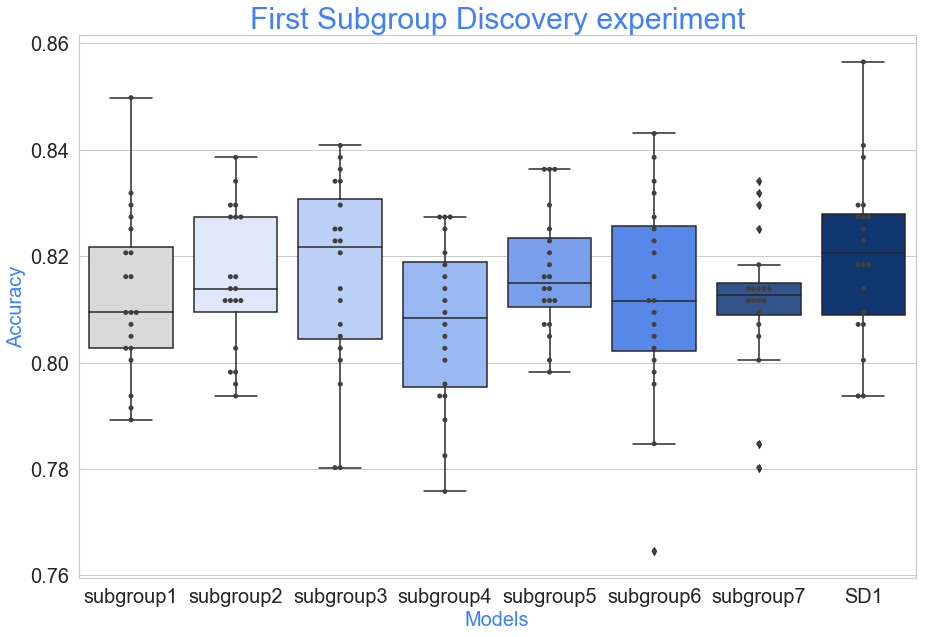

In [1229]:
return_plot(CrossVal_results_SD1['Accuracy'].iloc[:,2:-1], 'First Subgroup Discovery experiment', file_name = 'SD1.eps' )

In [834]:
result = CrossVal_results_SD1['Accuracy']

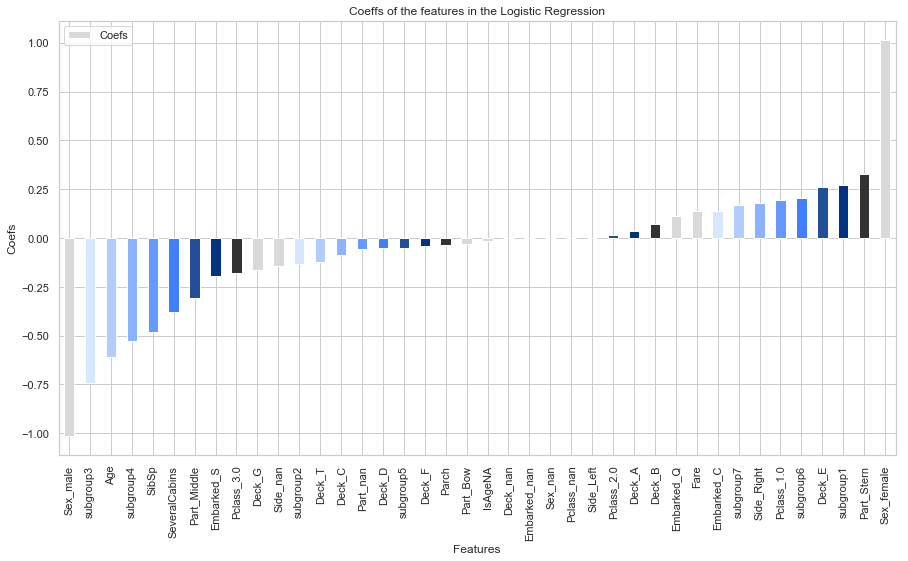

In [1281]:
#построим график коэффицентов регрессоров в модели SD1


labels  = pd.get_dummies(CrossVal_results_SD1['X_test'], dummy_na=True).columns
values = CrossVal_results_SD1['Coefs'][0]

df = pd.DataFrame({'Features' : labels , 'Coefs' : values})
df = df.sort_values('Coefs')

fig, ax = plt.subplots(figsize=(15, 8))
df.plot(kind='bar', x='Features', y='Coefs', ax=ax)



#x = np.arange(len(labels))  # the label locations

#rects1 = ax.bar(x, CrossVal_results_SD1['Coefs'][0] )



# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Coefs')
ax.set_title('Coeffs of the features in the Logistic Regression')


plt.savefig("Coefs.eps", format='eps')
plt.show()

#Generally, positive coefficients make the event more likely and negative coefficients make the event less likely.
#An estimated coefficient near 0 implies that the effect of the predictor is small.

In [836]:
final3 =  pd.concat([final, subgroup1, subgroup6, subgroup7, subgroup3], axis = 1)
final3 = final3.rename({0: 'subgroup1', 1: 'subgroup6', 2: 'subgroup7', 3: 'subgroup3'}, axis = 1)

In [ ]:
columns_to_drop = ['Survived','CabinNum', 'Deck',  'IsAgeNA', 'Parch'] 
CrossVal_results_SD2 = cross_val(cv_Num, final3, cv_prop, 'SD2', result, columns_to_drop)

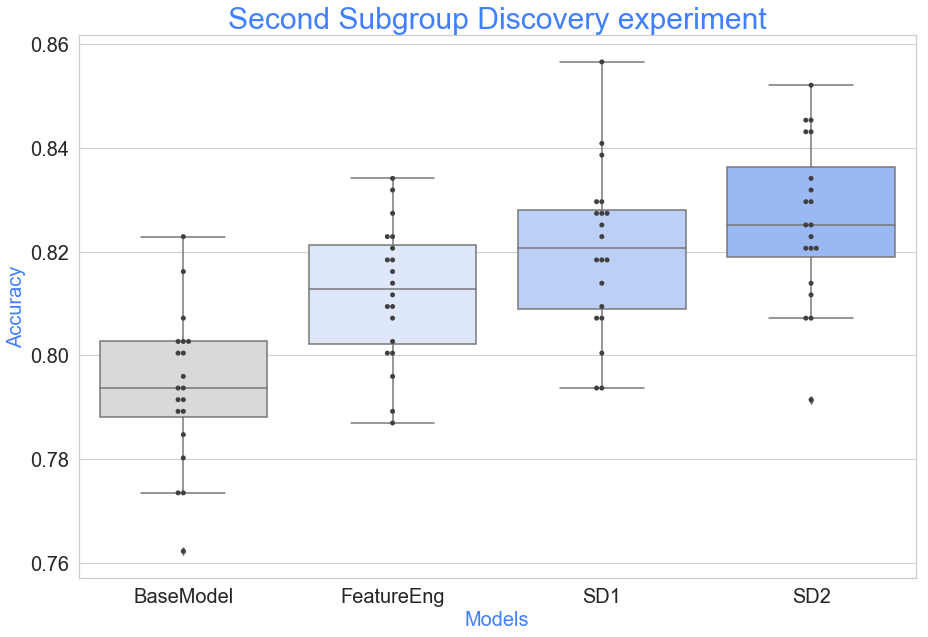

In [1235]:
return_plot(CrossVal_results_SD1['Accuracy'][['BaseModel', 'FeatureEng', 'SD1', 'SD2']], 'Second Subgroup Discovery experiment', file_name = 'SD2.eps' )

In [846]:
result = CrossVal_results_SD2['Accuracy']

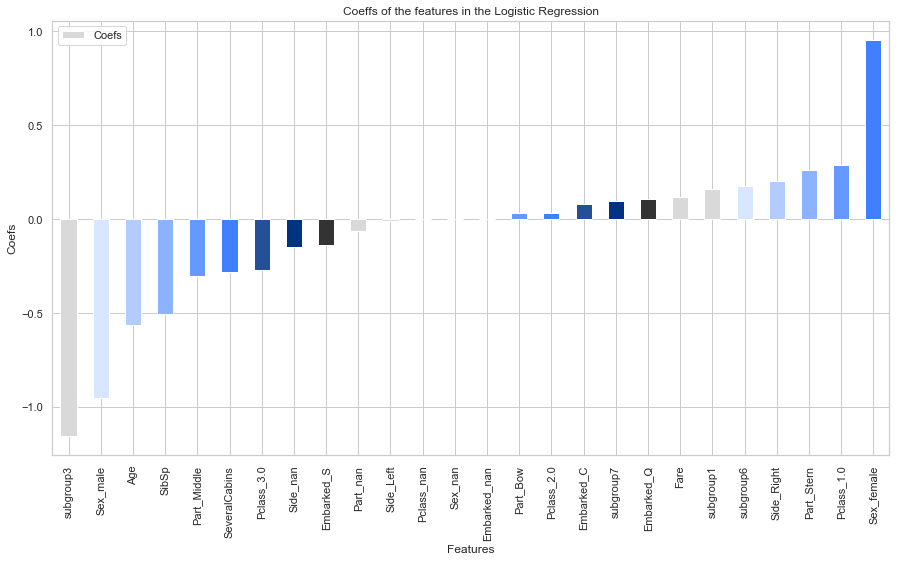

In [1335]:
#построим график коэффицентов регрессоров в модели SD3
labels  = pd.get_dummies(CrossVal_results_SD2['X_test'].drop(columns = 'error'), dummy_na=True).columns
values = CrossVal_results_SD2['Coefs'][0]

df = pd.DataFrame({'Features' : labels , 'Coefs' : values})
df = df.sort_values('Coefs')

fig, ax = plt.subplots(figsize=(15, 8))
df.plot(kind='bar', x='Features', y='Coefs', ax=ax)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Coefs')
ax.set_title('Coeffs of the features in the Logistic Regression')

plt.savefig('Coefs2.eps', format='eps')
plt.show()

#Generally, positive coefficients make the event more likely and negative coefficients make the event less likely.
#An estimated coefficient near 0 implies that the effect of the predictor is small.



In [1336]:
df

,Features,Coefs
7,subgroup3,-1.154383
13,Sex_male,-0.952192
0,Age,-0.566672
1,SibSp,-0.505703
23,Part_Middle,-0.304995
3,SeveralCabins,-0.284135
10,Pclass_3.0,-0.271706
21,Side_nan,-0.150215
17,Embarked_S,-0.137798
25,Part_nan,-0.066037


### Subgroup discovery 2 раунд

Возьмем тестовую часть из датасета final2 (содержит в себе все подгруппы) и проведем поиск подгруп subgroup discovery еще раз

In [847]:
dataX = CrossVal_results_SD2['X_test'] #dataset
y_true = CrossVal_results_SD2['y_test'] 
y_pred = CrossVal_results_SD2['Preds'] 

In [849]:
dataX['error'] = [1 if y_true[i] != y_pred[i] else 0 for i in range(len(y_true))]

### Первый набор подгрупп

In [850]:
results = find_subgroups(dataX)
for (q,sg) in results:
    print(str(q) + ":\t" + str(sg.subgroup_description))

0.01828912706871242:	SeveralCabins=False
0.01828912706871242:	SeveralCabins=False AND subgroup1=False
0.016841279736170032:	SeveralCabins=False AND subgroup1=False AND subgroup6=False
0.016841279736170032:	SeveralCabins=False AND subgroup6=False
0.016429045426210057:	Fare: [11.50:23.0[ AND Embarked=S


subgroup1 = (Part == Stern) & (SeveralCabins == True)

В подгруппе 1 уже учтен признак SeveralCabins, то есть сочетание (SeveralCabins=False AND subgroup1=False) не приносит новой информации. Разве что Part != Stern

subgroup6 = (10.5 < Fare > 23.25) & (SibSp == 1)

Сочетание (SeveralCabins=False AND subgroup6=False) означает, что кол-во siblings != 1 и Fare не в промежутке от 10.5 и 23.25, и нет нескольких кабин

In [1238]:
subgroup10 = pd.Series([((final2.loc[x, "subgroup6"] == False) & (final2.loc[x, "SeveralCabins"] == False) ) for x in range(len(final2))])

Также используем подгруппу (Fare: [11.50:23.0[ AND Embarked=S )

In [852]:
subgroup11 = pd.Series([((final2.loc[x, "Fare"] >= 11.5) & (final2.loc[x, "Fare"] < 23) & (final2.loc[x, "Embarked"] == 'S') ) for x in range(len(final2))])

### Второй набор подгрупп

In [854]:
results = find_subgroups(dataX, ignore = ['error', 'SeveralCabins'])
for (q,sg) in results:
    print(str(q) + ":\t" + str(sg.subgroup_description))

0.016429045426210057:	Fare: [11.50:23.0[ AND Embarked=S
0.015775503227493007:	Part=Stern AND Sex=female
0.015302941945343759:	Fare: [11.50:23.0[
0.01455890928834281:	SibSp: [1:2[ AND subgroup7=True
0.01455890928834281:	subgroup7=True


Сочетание (Fare: [11.50:23.0[ AND Embarked=S) уже добавлено в subgroup11

Сочетание Part=Stern AND Sex=female было ранее в subgroup4, но из-за небольшого коэффициента было исключено. Вернем

Добавим признак  Fare: [11.50:23.0[

In [859]:
subgroup12 = pd.Series([((final2.loc[x, "Fare"] >= 11.5) & (final2.loc[x, "Fare"] < 23) ) for x in range(len(final2))])

В подгруппе subgroup7 уже учтено SibSp=1,поэтому сочетание (SibSp: [1:2[ AND subgroup7=True) не приносит новой информации

### Третий набор подгрупп

In [861]:
results = find_subgroups(dataX, ignore = ['error', 'SeveralCabins', 'Fare', 'Part', 'Sex'])
for (q,sg) in results:
    print(str(q) + ":\t" + str(sg.subgroup_description))

0.01455890928834281:	SibSp: [1:2[ AND Embarked=S AND subgroup7=True
0.01455890928834281:	SibSp: [1:2[ AND Embarked=S
0.01455890928834281:	SibSp: [1:2[ AND subgroup7=True
0.01455890928834281:	subgroup7=True
0.01455890928834281:	subgroup7=True AND Embarked=S


В подгруппе subgroup7 уже учтено,  что SibSp=1 и Embarked = S

In [863]:
results = find_subgroups(dataX, ignore = ['error', 'SeveralCabins', 'Fare', 'Part', 'Sex', 'SibSp', 'Embarked'])
for (q,sg) in results:
    print(str(q) + ":\t" + str(sg.subgroup_description))

0.01455890928834281:	subgroup7=True
0.013674113696233583:	subgroup3=True
0.013674113696233583:	subgroup3=True AND Pclass=3
0.0108789639847976:	subgroup7=True AND subgroup6=True
0.01045667517947274:	subgroup6=True


Сочетание (subgroup3=True AND Pclass=3) не приносит новой информации, тк класс уже учтен в подгруппе subgroup3

In [865]:
subgroup13 = pd.Series([((final2.loc[x, "subgroup7"] == True) & (final2.loc[x, "subgroup6"] == True) ) for x in range(len(final2))])

In [1273]:
cols = list(set(CrossVal_results_SD2['X_test'].columns[:-1]) ^ set(['Survived','CabinNum'])) ## [:-1] - не берем колонку error

In [1274]:
dataSD3 = final2[cols] 

In [889]:
#в переменной res сейчас только два столбика: BaseModel и FeatureEng
#добавим результаты SD1 SD2  в res
res = result[['BaseModel', 'FeatureEng', 'SD1', 'SD2']].copy()

In [1275]:
#поочередно добавляем новые признаки (со второго раунда) и смотрим, что меняется
list_of_features = [subgroup10, subgroup11, subgroup12, subgroup13]
list_of_names = ['subgroup10', 'subgroup11', 'subgroup12', 'subgroup13']
columns_to_drop = ['Survived','CabinNum'] 

for i in range(0,4) :
    df = pd.concat([dataSD3, list_of_features[i]], axis = 1)
    CrossVal_result= cross_val(cv_Num, df, cv_prop, list_of_names[i], res, columns_to_drop)

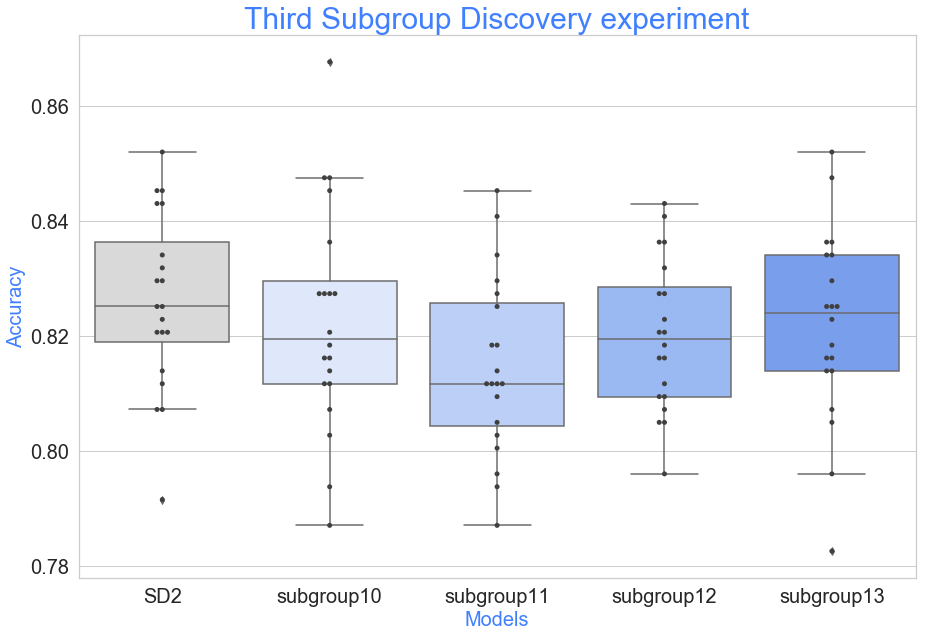

In [1278]:
return_plot(CrossVal_result['Accuracy'][['SD2', 'subgroup10', 'subgroup11', 'subgroup12', 'subgroup13']] ,  'Third Subgroup Discovery experiment', file_name = 'SD3_2.eps'  )

In [1239]:
final4 = pd.concat([final2[cols], subgroup4, subgroup10, subgroup11, subgroup12, subgroup13], axis = 1)
final4 = final4.rename({0: 'subgroup4', 1: 'subgroup10', 2: 'subgroup11', 3: 'subgroup12', 4: 'subgroup13'}, axis = 1)

In [1265]:
columns_to_drop = ['Survived','CabinNum'] 
CrossVal_results_SD3 = cross_val(cv_Num, final4, cv_prop, 'SD3', res, columns_to_drop)

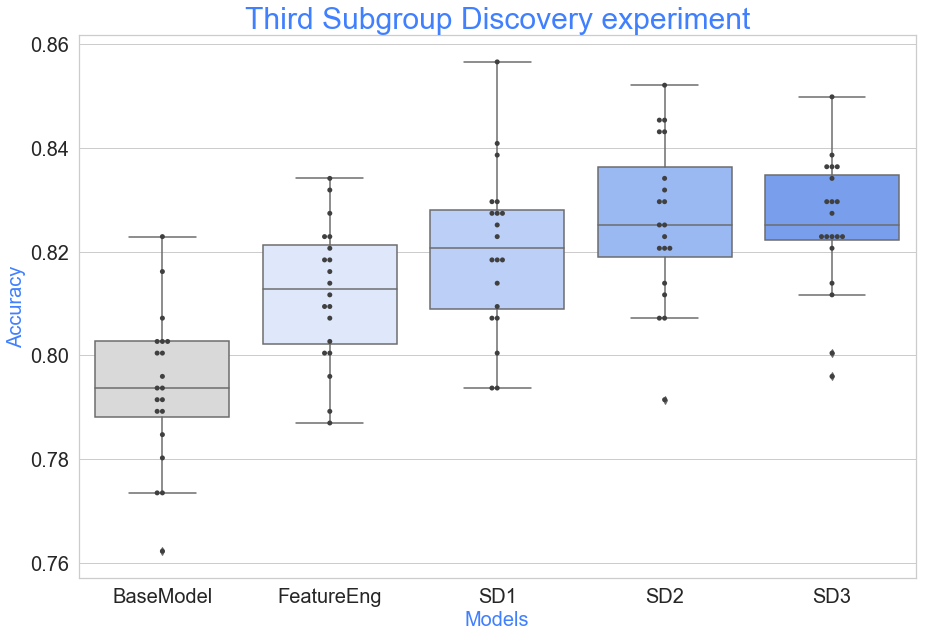

In [1272]:
return_plot(CrossVal_results_SD3['Accuracy'][['BaseModel', 'FeatureEng', 'SD1', 'SD2', 'SD3']] ,  'Third Subgroup Discovery experiment', file_name = 'SD3.eps'  )

In [1334]:
labels

Index(['Age', 'SibSp', 'Fare', 'SeveralCabins', 'subgroup1', 'subgroup6',
       'subgroup7', 'subgroup3', 'error', 'Pclass_1.0', 'Pclass_2.0',
       'Pclass_3.0', 'Pclass_nan', 'Sex_female', 'Sex_male', 'Sex_nan',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Embarked_nan', 'Side_Left',
       'Side_Right', 'Side_nan', 'Part_Bow', 'Part_Middle', 'Part_Stern',
       'Part_nan'],
      dtype='object')

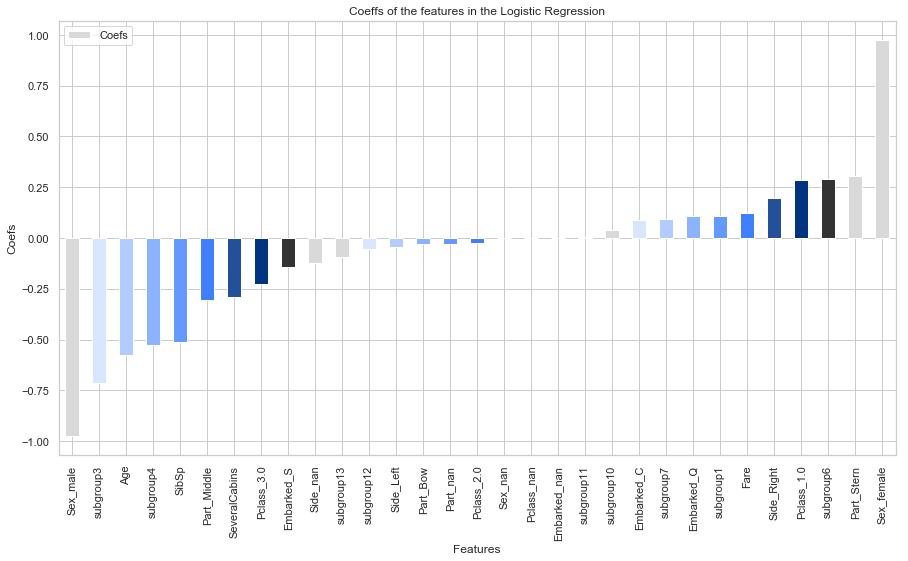

In [1323]:
#построим график коэффицентов регрессоров в модели SD3
labels  = pd.get_dummies(CrossVal_results_SD3['X_test'], dummy_na=True).columns
values = CrossVal_results_SD3['Coefs'][0]

df = pd.DataFrame({'Features' : labels , 'Coefs' : values})
df = df.sort_values('Coefs')

fig, ax = plt.subplots(figsize=(15, 8))
df.plot(kind='bar', x='Features', y='Coefs', ax=ax)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Coefs')
ax.set_title('Coeffs of the features in the Logistic Regression')

plt.savefig('Coefs2.eps', format='eps')
plt.show()

#Generally, positive coefficients make the event more likely and negative coefficients make the event less likely.
#An estimated coefficient near 0 implies that the effect of the predictor is small.

In [1324]:
df

,Features,Coefs
25,Sex_male,-0.972941
5,subgroup3,-0.711435
0,Age,-0.578038
8,subgroup4,-0.526418
3,SibSp,-0.509654
21,Part_Middle,-0.307172
6,SeveralCabins,-0.291286
18,Pclass_3.0,-0.227184
29,Embarked_S,-0.142729
15,Side_nan,-0.120900


До этого мы искали подгруппы только среди наблюдений, на которых произошла ошибка. Попробуем найти подгруппы, на которых ошибки не было.

### Subgroup discovery 3 раунд

In [973]:
results = find_subgroups(dataX, ignore = ['error'], nom_sel = False)
for (q,sg) in results:
    print(str(q) + ":\t" + str(sg.subgroup_description))

0.03191296828812164:	SeveralCabins=True AND subgroup6=False AND subgroup3=False
0.03158116994108068:	subgroup7=False AND subgroup3=False AND SeveralCabins=True
0.02938928995153733:	SeveralCabins=True AND subgroup1=False AND subgroup6=False
0.02920830903496954:	subgroup7=False AND SeveralCabins=True
0.029057491604496378:	SeveralCabins=True AND subgroup1=False AND subgroup7=False


In [974]:
subgroup14 = pd.Series([((final2.loc[x, "SeveralCabins"] == True) & (final2.loc[x, "subgroup6"] == False) & (final2.loc[x, "subgroup3"] == False)) for x in range(len(final2))])

In [975]:
subgroup15 = pd.Series([((final2.loc[x, "subgroup7"] == False) & (final2.loc[x, "subgroup3"] == False) & (final2.loc[x, "SeveralCabins"] == True)) for x in range(len(final2))])

In [976]:
subgroup16 = pd.Series([((final2.loc[x, "SeveralCabins"] == True) & (final2.loc[x, "subgroup1"] == False) & (final2.loc[x, "subgroup6"] == False)) for x in range(len(final2))])

In [977]:
subgroup17 = pd.Series([((final2.loc[x, "subgroup7"] == False) & (final2.loc[x, "SeveralCabins"] == True)) for x in range(len(final2))])

In [978]:
subgroup18 = pd.Series([((final2.loc[x, "SeveralCabins"] == True) & (final2.loc[x, "subgroup1"] == False) & (final2.loc[x, "subgroup7"] == False)) for x in range(len(final2))])

In [1288]:
res = result[['BaseModel', 'FeatureEng', 'SD1', 'SD2', 'SD3']].copy()

In [1297]:
#поочередно добавляем новые признаки (со третьего раунда) и смотрим, что меняется
list_of_features = [subgroup14, subgroup15, subgroup16, subgroup17, subgroup18]
list_of_names = ['subgroup14', 'subgroup15', 'subgroup16', 'subgroup17', 'subgroup18']
columns_to_drop = ['Survived','CabinNum'] 

for i in range(0,5) :
    df = pd.concat([final3, list_of_features[i]], axis = 1)
    CrossVal_result= cross_val(cv_Num, df, cv_prop, list_of_names[i], res, columns_to_drop)

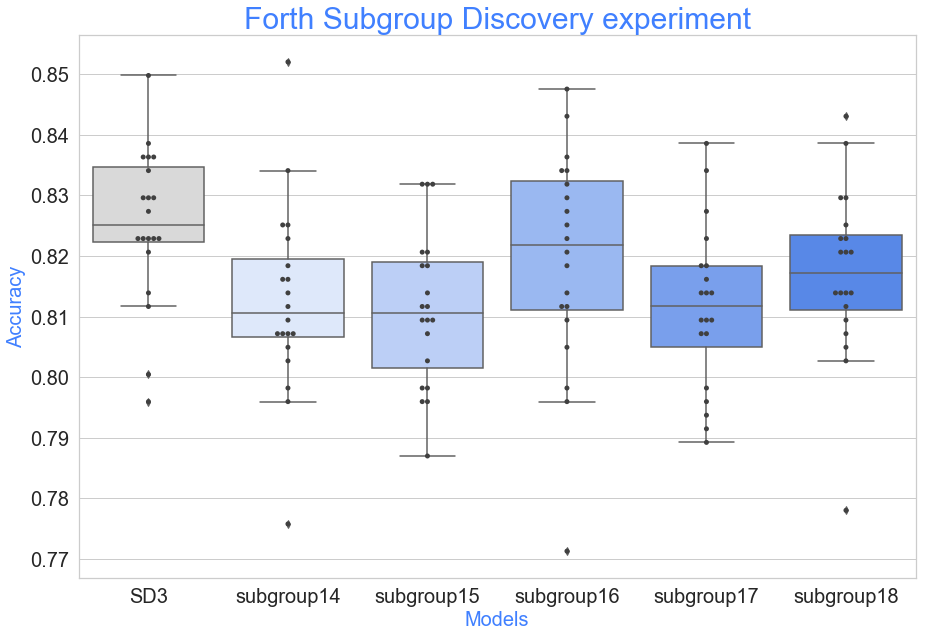

In [1302]:
return_plot(CrossVal_result['Accuracy'][['SD3', 'subgroup14', 'subgroup15', 'subgroup16', 'subgroup17', 'subgroup18']],  'Forth Subgroup Discovery experiment', file_name = 'SD4_2.eps'  )

In [1304]:
res = result[['BaseModel', 'FeatureEng', 'SD1', 'SD2', 'SD3']].copy()

In [1305]:
final5 = pd.concat([final3, subgroup14, subgroup15, subgroup16, subgroup17, subgroup18], axis = 1)
final5 = final5.rename({0: 'subgroup14', 1: 'subgroup15', 2: 'subgroup16', 3: 'subgroup17', 4: 'subgroup18'}, axis = 1)

In [1318]:
columns_to_drop = ['Survived','CabinNum'] 
CrossVal_results_SD4 = cross_val(cv_Num, final5, cv_prop, 'SD4', res, columns_to_drop)

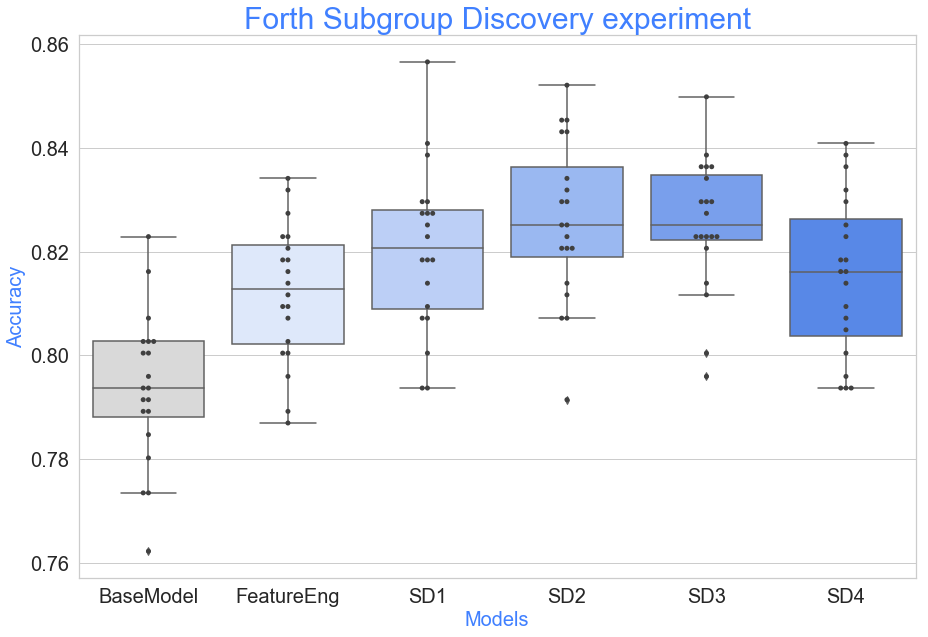

In [1320]:
result = CrossVal_results_SD4['Accuracy']
return_plot(CrossVal_results_SD4['Accuracy'],  'Forth Subgroup Discovery experiment', file_name = 'SD4.eps'  )

In [1321]:
result.mean()

BaseModel     0.793722
FeatureEng    0.811996
SD1           0.820291
SD2           0.826009
SD3           0.825224
SD4           0.815359
dtype: float64

In [1300]:
def return_plot(df, name, file_name) :
    # Set your custom color palette
    #colors = ["#24509A", "#A33E2E",  "#E78E2E", "#56AF40", "#D0941F", "#8D6CAB"] #вспомогательные вышкинские корпоративные цвета
    colors = ["#d9d9d9", "#d9e6ff", "#b3ccff", "#8cb3ff", "#6699ff", "#4080ff", "#24509A", '#003380', '#333333', ] #вышкинские корпоративные цвета
    _ = plt.figure(figsize=(15,10))
    _ = sns.set_style("whitegrid")
    _ = sns.set_palette(sns.color_palette(colors))


    #построим красивые графики

    ax = sns.boxplot(data=df, orient = 'v')
    ax = sns.swarmplot(data=df, color=".25")
    ax.set_ylabel('Accuracy', fontsize=20, color = "#4080ff")
    ax.set_xlabel('Models', fontsize=20, color = "#4080ff")
    ax.set_title(name, fontsize=30, color = "#4080ff")
    ax.tick_params(labelsize=20)
    plt.savefig(file_name, format='eps')
    plt.show()

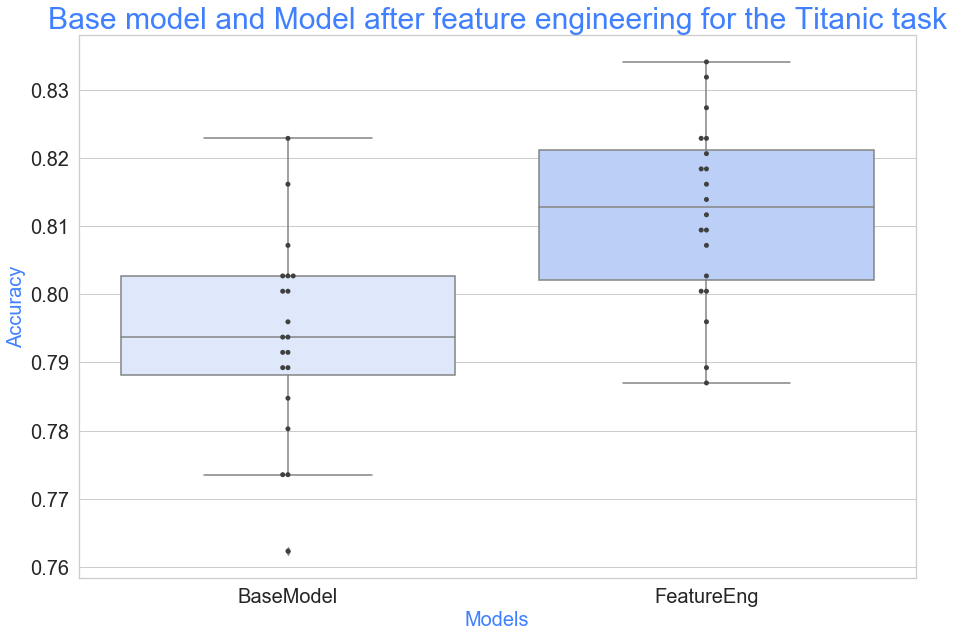

In [1216]:
#График, на котором показана первая базовая модель 
#и модель после добавления признаков, выявленных после анализа предметной области
return_plot(result[['BaseModel', 'FeatureEng']], 'Base model and Model after feature engineering for the Titanic task', file_name = 'first2models_acc.eps' )

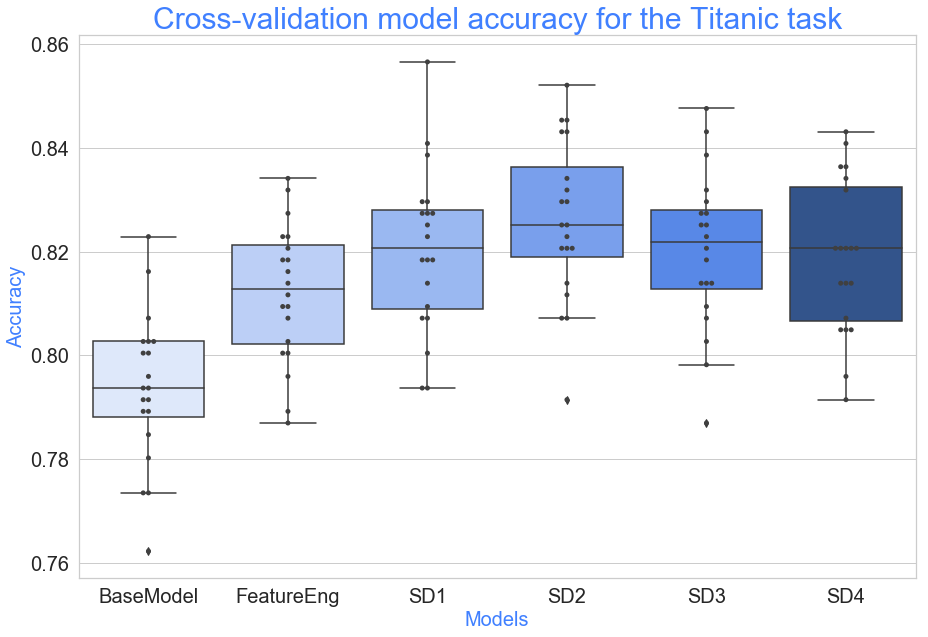

In [1217]:
#График, на котором собраны все полученные модели
return_plot(result, 'Cross-validation model accuracy for the Titanic task', file_name = 'allmodels_acc.eps' )